#### Import libraries

In [1]:
import sys; sys.path.append("/glade/u/home/gmarques/libs/mom6-tools/")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
_ = xr.set_options(display_style='text')
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot, yzplot

%matplotlib inline

Basemap module not found. Some regional plots may not function properly


In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=8, # The number of cores you want
    memory='50GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=8:mem=50GB', # Specify resources
    project='P93300012', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(2)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.12.206.60:45478 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/altuntas/proxy/35565/status,Cluster Workers: 2 Cores: 16 Memory: 100.00 GB


#### Auxiliary plotting functions

In [5]:
def open_mfdataset_minimal(full_path, variables, **kwargs):
    ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=lambda ds:ds[variables], **kwargs)
    return ds

def summer_mean(fld):
    sm = xr.where(fld.yh<0, fld.resample(time="QS-JAN").mean()[::4].mean(dim="time"), fld.resample(time="QS-JAN").mean()[2::4].mean(dim="time"))
    sm.attrs = fld.attrs
    sm.name = "Summer means of "+fld.name
    return sm

def winter_mean(fld):
    sm = xr.where(fld.yh>0, fld.resample(time="QS-JAN").mean()[::4].mean(dim="time"), fld.resample(time="QS-JAN").mean()[2::4].mean(dim="time"))
    sm.attrs = fld.attrs
    sm.name = "Summer means of "+fld.name
    return sm

def add_season_labels(ax, season):
    if season=="winter":
        nh='JFM'; sh='JAS'
    elif season=="summer":
        nh='JAS'; sh='JFM'
    else:
        raise RuntimeError("unknown season")
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'w--', lw=1.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)

def get_plot_title(fld):
    return "{}: {} ({})".format(fld.name, fld.attrs['long_name'], fld.attrs['units'])

def plot_field(fld, clim, zl=None, z_l=None):
    if zl is not None:
        xyplot(fld.isel(zl=zl).mean(dim='time'), grd.geolon, grd.geolat, grd.area_t, title=get_plot_title(fld), 
           colormap=plt.cm.bwr, nbins=100, clim=clim)
    elif z_l  is not None:
        xyplot(fld.isel(z_l=z_l).mean(dim='time'), grd.geolon, grd.geolat, grd.area_t, title=get_plot_title(fld), 
           colormap=plt.cm.bwr, nbins=100, clim=clim)
    else:
        raise RuntimeError("Provide zl or z_l")
        
def plot_comparison(grd, fld1, title1, fld2, title2, nmth=None, clim=None, clim_diff=None, zl=None, z_l=None, 
                    cmap=plt.cm.nipy_spectral, season=None):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
    ax1 = ax.flatten()
    plt.suptitle(get_plot_title(fld1))

            
    if zl is not None:
        fld1 = fld1.isel(zl=zl)
        fld2 = fld2.isel(zl=zl)            
    if z_l is not None:
        fld1 = fld1.isel(z_l=z_l)
        fld2 = fld2.isel(z_l=z_l)
        
    # sub and mean
    if nmth is not None and 'time' in fld1.dims: 
        fld1 = fld1.isel(time=slice(0,nmth)).mean(dim='time')
    if nmth is not None and 'time' in fld2.dims:
        fld2 = fld2.isel(time=slice(0,nmth)).mean(dim='time')
        
        
    xyplot(np.ma.masked_invalid(fld1), grd.geolon, grd.geolat, grd.area_t, title=title1, 
       axis=ax1[0], nbins=100, colormap=cmap, clim=clim)
    xyplot(np.ma.masked_invalid(fld2), grd.geolon, grd.geolat, grd.area_t, title=title2, 
       axis=ax1[1], nbins=100, colormap=cmap, clim=clim)
    xyplot(np.ma.masked_invalid(fld1-fld2), grd.geolon, grd.geolat, grd.area_t, title='diff', 
       axis=ax1[2],nbins=40, colormap=cmap, clim=clim_diff)
    
    if season is not None:
        add_season_labels(ax1[0], season)
        add_season_labels(ax1[1], season)

def get_clim(fld):
    maxval = fld.max().data.compute()
    minval = fld.min().data.compute()
    
    if minval <= 0.0 and maxval >= 0.0:
        absmax = max(-minval, maxval)
        return (-absmax, absmax)
    else:
        return (minval, maxval)

#### Load MOM6 grid and history data

In [6]:
base_casename = "g.e23.GMOM_JRA.TL319_t061.control.nowav.001"
archive_path = '/glade/scratch/altuntas/archive/{}/ocn/hist/'.format(base_casename)
grd = MOM6grid(archive_path+'{}.mom6.static.nc'.format(base_casename));
grd_xr = MOM6grid(archive_path+'{}.mom6.static.nc'.format(base_casename), xrformat=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



---------------------

# CASES:

### g.e23.GMOM_JRA.TL319_t061.control.nowav.001 : nw1
 - No waves
 - Out-of-the-box GMOM_JRA configuration.
 
### g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.legacy.001 : lg1
 - WW3 v.7 (latest)
 - wave grid: wt061
 - enhanced turbulent velocity scale
 
### g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.surfbands.001 : sb1
 - WW3 v.7 (latest)
 - wave grid: wt061
 - No KPP enhancement
 - WAB terms

# Surface Fields - Mean of the first 20 years (JRA years 30-49)

In [7]:
sfields = ['oml','SSH','tos','sos','SSU','SSV','thetaoga','soga','T_ady_2d','T_diffy_2d']
tdate = "00*"
nmth = 240

In [8]:
casename = "g.e23.GMOM_JRA.TL319_t061.control.nowav.001"
nw1_mom_hm = open_mfdataset_minimal("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_{}*.nc".format(casename, tdate), variables=sfields, parallel=True).isel(time=slice(0,nmth))
casename = "g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.legacy.001"
lg1_mom_hm = open_mfdataset_minimal("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_{}*.nc".format(casename, tdate), variables=sfields, parallel=True).isel(time=slice(0,nmth))
casename = "g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.surfbands.001"
sb1_mom_hm = open_mfdataset_minimal("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_{}*.nc".format(casename, tdate), variables=sfields, parallel=True).isel(time=slice(0,nmth))

## Summer means of boundary layer depth 

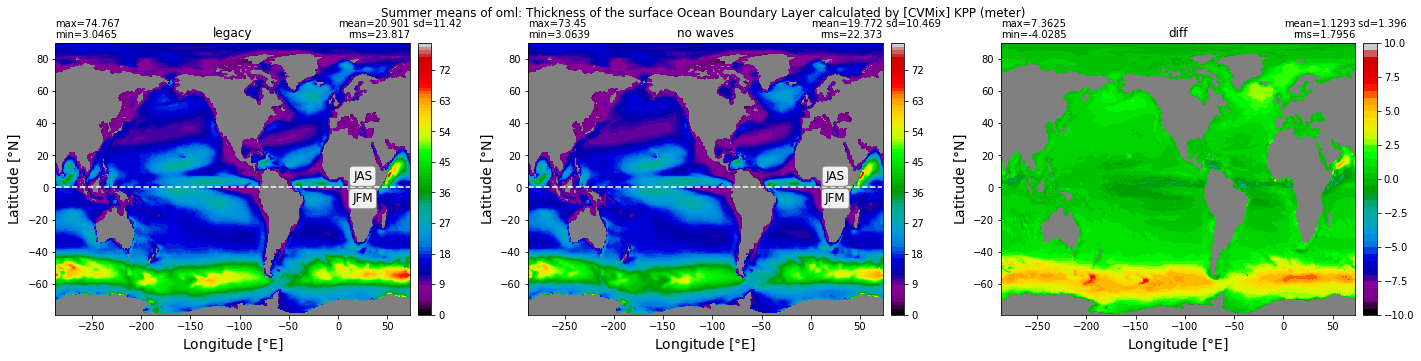

In [9]:
plot_comparison(grd,
                fld1 = summer_mean(lg1_mom_hm.oml), title1= "legacy",
                fld2 = summer_mean(nw1_mom_hm.oml), title2= "no waves",
                clim = (0,80), clim_diff = (-10,10), season="summer" ) 

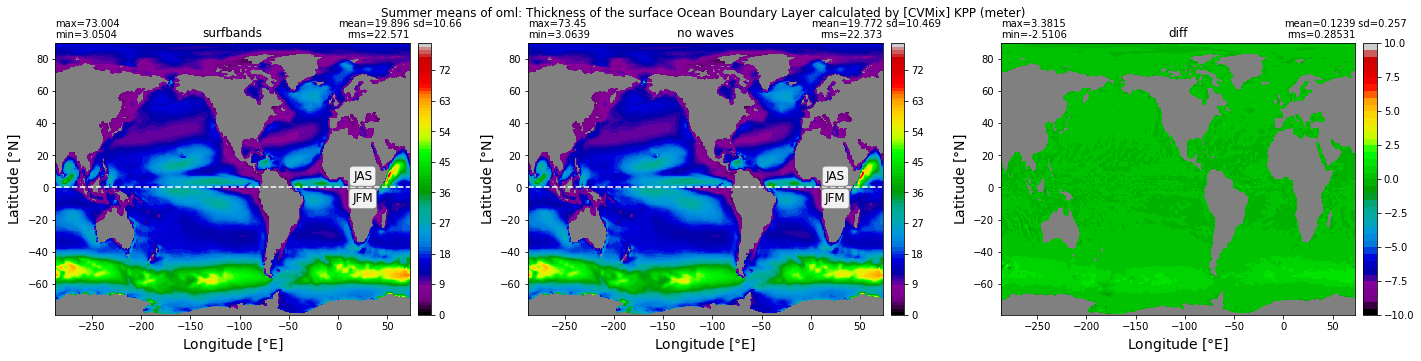

In [10]:
plot_comparison(grd,
                fld1 = summer_mean(sb1_mom_hm.oml), title1= "surfbands",
                fld2 = summer_mean(nw1_mom_hm.oml), title2= "no waves",
                clim = (0,80), clim_diff = (-10,10), season="summer" ) 

## Winter means of boundary layer depth 

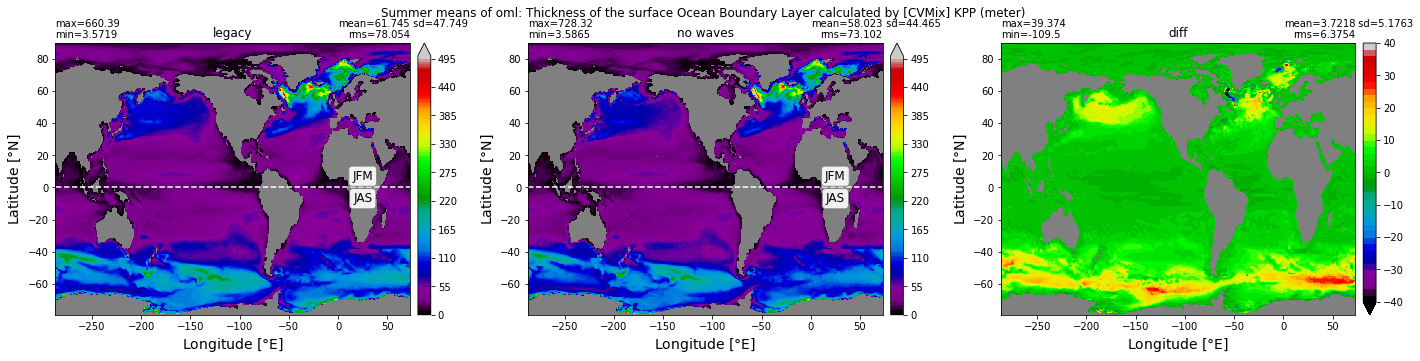

In [11]:
plot_comparison(grd,
                fld1 = winter_mean(lg1_mom_hm.oml), title1= "legacy",
                fld2 = winter_mean(nw1_mom_hm.oml), title2= "no waves",
                clim = (0,500), clim_diff = (-40,40), season="winter" ) 

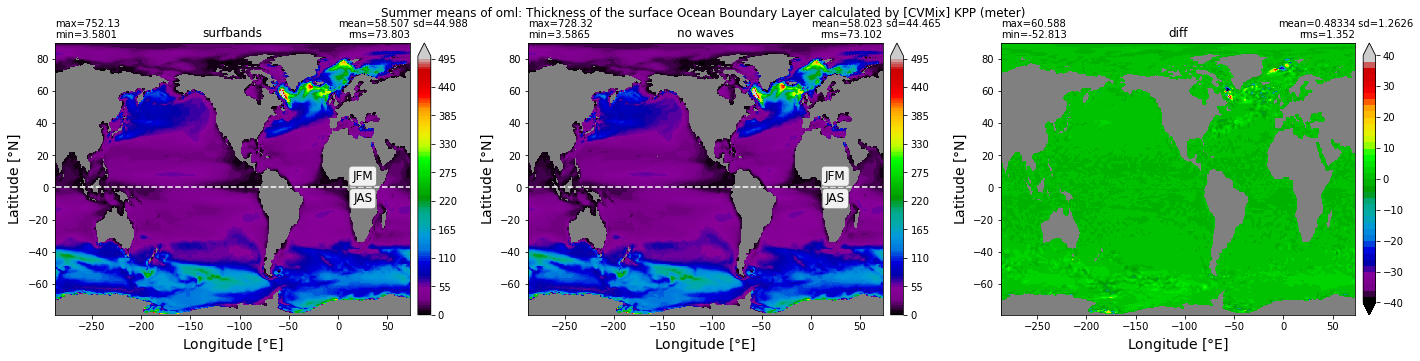

In [12]:
plot_comparison(grd,
                fld1 = winter_mean(sb1_mom_hm.oml), title1= "surfbands",
                fld2 = winter_mean(nw1_mom_hm.oml), title2= "no waves",
                clim = (0,500), clim_diff = (-40,40), season="winter" ) 

## SST

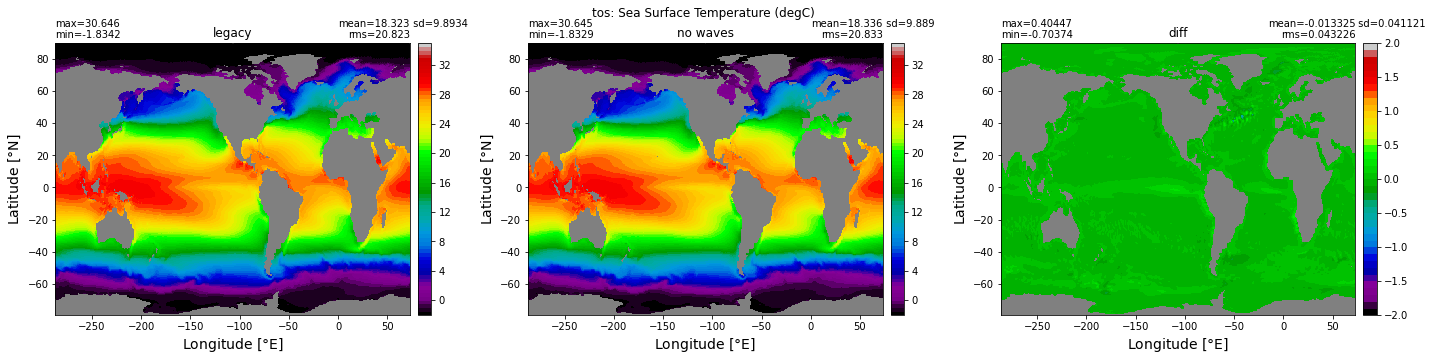

In [13]:
plot_comparison(grd,
                fld1 = lg1_mom_hm.tos, title1= "legacy",
                fld2 = nw1_mom_hm.tos, title2= "no waves",
                nmth=nmth, clim = (-2,35), clim_diff = (-2,2)) 

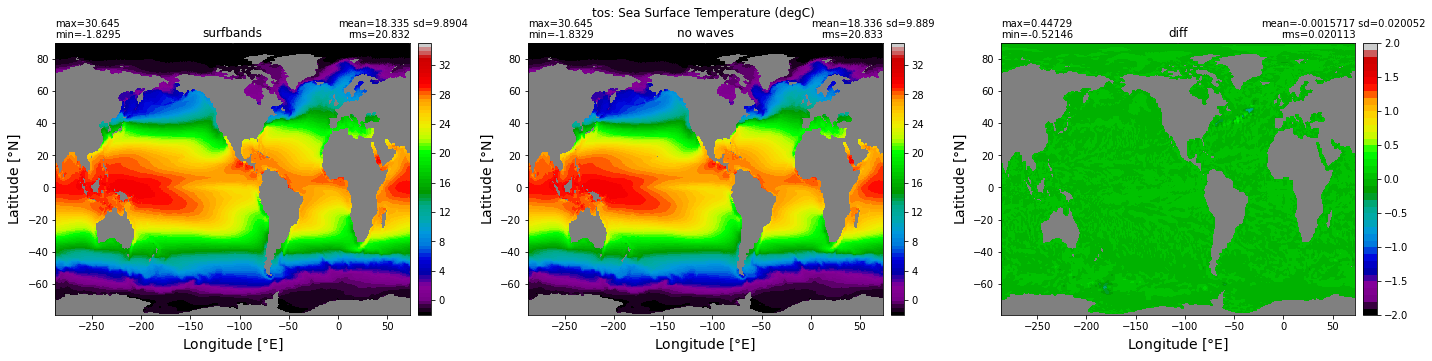

In [14]:
plot_comparison(grd,
                fld1 = sb1_mom_hm.tos, title1= "surfbands",
                fld2 = nw1_mom_hm.tos, title2= "no waves",
                nmth=nmth, clim = (-2,35), clim_diff = (-2,2) ) 

## SSS

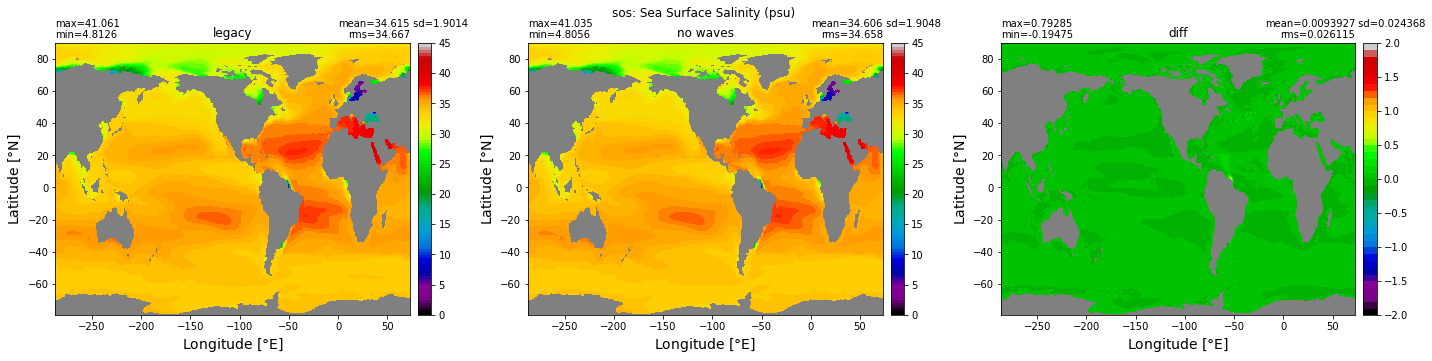

In [15]:
plot_comparison(grd,
                fld1 = lg1_mom_hm.sos, title1= "legacy",
                fld2 = nw1_mom_hm.sos, title2= "no waves",
                nmth=nmth, clim = (0,45), clim_diff = (-2,2)) 

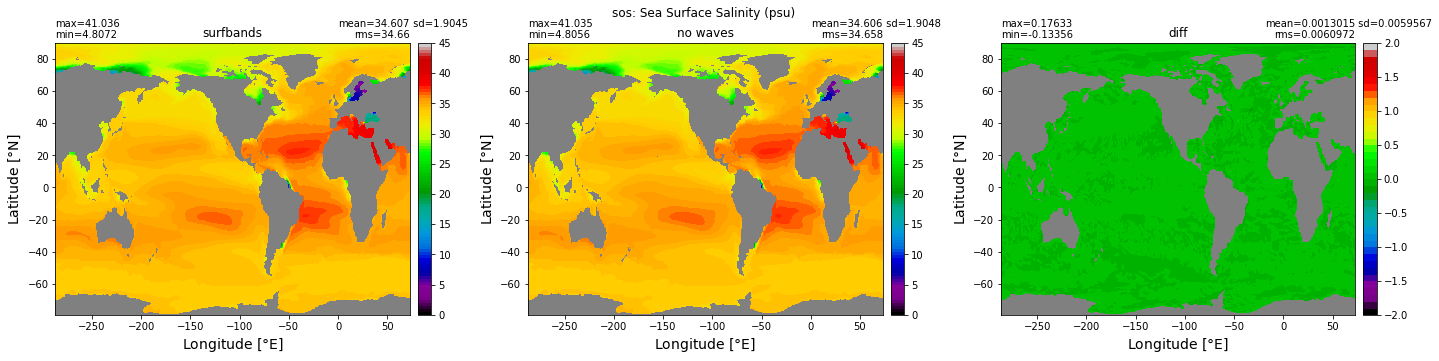

In [16]:
plot_comparison(grd,
                fld1 = sb1_mom_hm.sos, title1= "surfbands",
                fld2 = nw1_mom_hm.sos, title2= "no waves",
                nmth=nmth, clim = (0,45), clim_diff = (-2,2)) 

# SSU & SSV

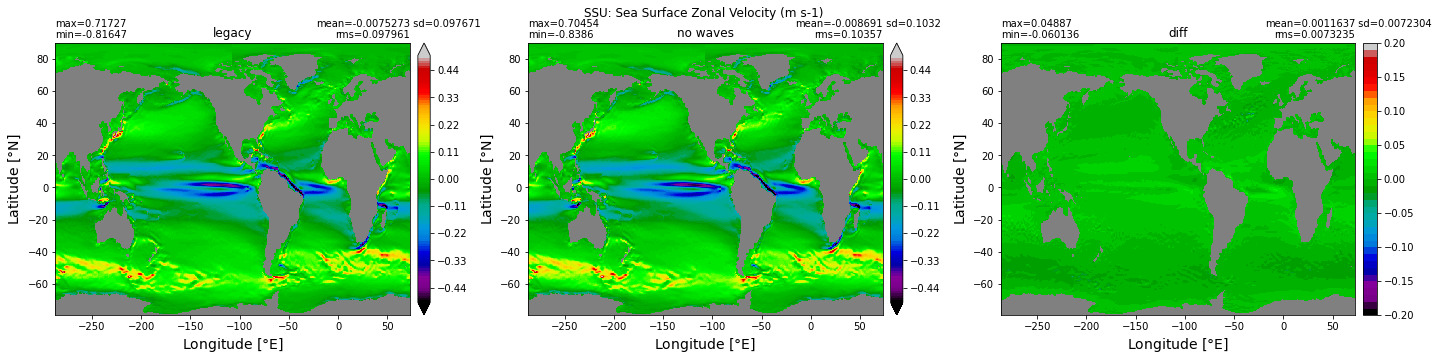

In [17]:
plot_comparison(grd,
                fld1 = lg1_mom_hm.SSU, title1= "legacy",
                fld2 = nw1_mom_hm.SSU, title2= "no waves",
                nmth=nmth, clim = (-0.5,0.5), clim_diff = (-0.2,0.2)) 

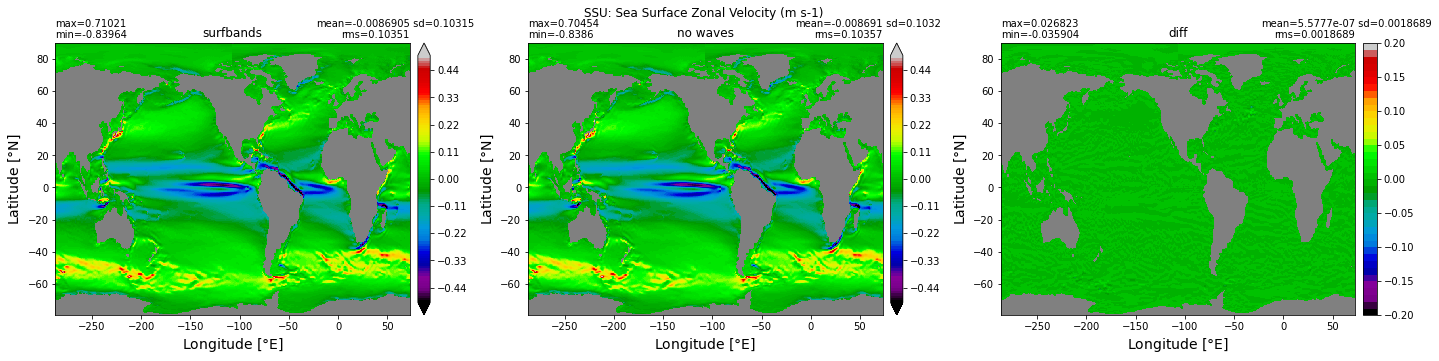

In [18]:
plot_comparison(grd,
                fld1 = sb1_mom_hm.SSU, title1= "surfbands",
                fld2 = nw1_mom_hm.SSU, title2= "no waves",
                nmth=nmth, clim = (-0.5,0.5), clim_diff = (-0.2,0.2)) 

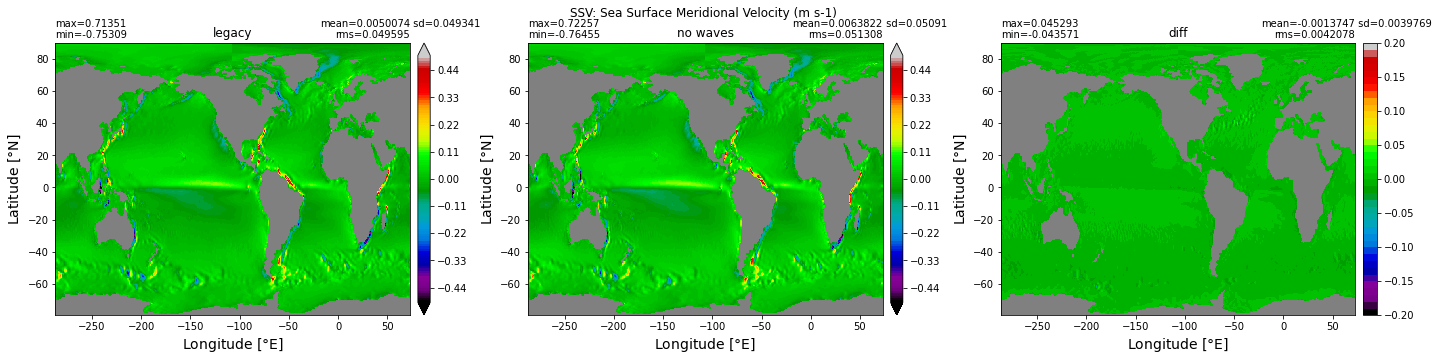

In [19]:
plot_comparison(grd,
                fld1 = lg1_mom_hm.SSV, title1= "legacy",
                fld2 = nw1_mom_hm.SSV, title2= "no waves",
                nmth=nmth, clim = (-0.5,0.5), clim_diff = (-0.2,0.2)) 

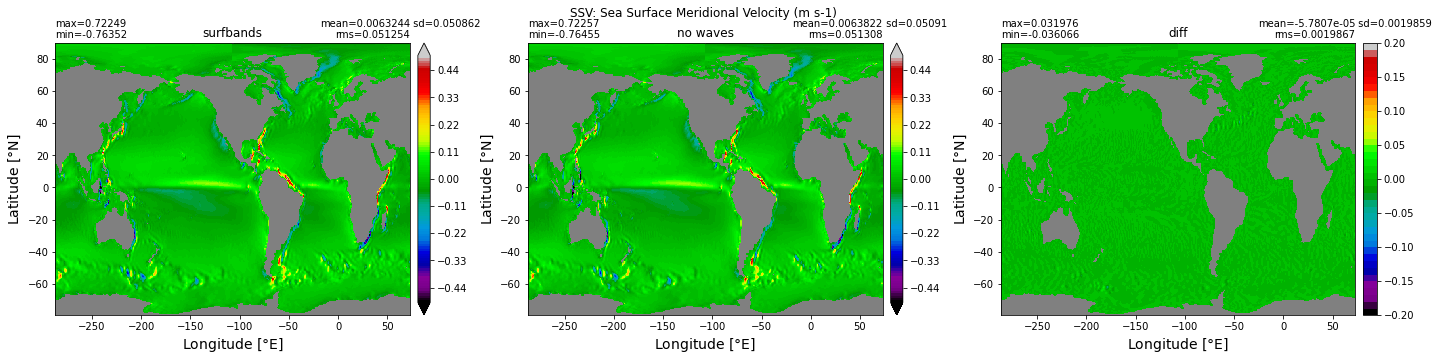

In [20]:
plot_comparison(grd,
                fld1 = sb1_mom_hm.SSV, title1= "surfbands",
                fld2 = nw1_mom_hm.SSV, title2= "no waves",
                nmth=nmth, clim = (-0.5,0.5), clim_diff = (-0.2,0.2)) 

# Global Heat Transport

In [21]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

(-2.0, 2.5)

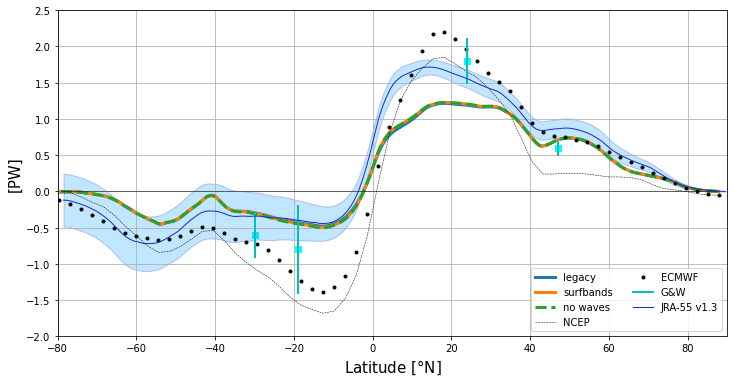

In [22]:
plt.figure(figsize=(12,6))

def plot_heat_trans(ds, label, linestyle='-'):
    adv, diff = get_adv_diff(ds)
    HT = heatTrans(adv,diff); y = ds.yq
    plt.plot(y, HT, linewidth=3, linestyle=linestyle, label=label)
    
plot_heat_trans(lg1_mom_hm, label="legacy")
plot_heat_trans(sb1_mom_hm, label="surfbands")
plot_heat_trans(nw1_mom_hm, label="no waves", linestyle='--')

y = nw1_mom_hm.yq
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); 
plt.plot(y, y*0., 'k', linewidth=0.5)
plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF')
plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err'])
jra = xr.open_dataset('/glade/work/gmarques/cesm/datasets/Heat_transport/jra55fcst_v1_3_annual_1x1/nht_jra55do_v1_3.nc')
jra_mean_global = jra.nht[:,0,:].mean('time').values
jra_std_global = jra.nht[:,0,:].std('time').values
plt.plot(jra.lat, jra_mean_global,'k', label='JRA-55 v1.3', color='#1B2ACC', lw=1)
plt.fill_between(jra.lat, jra_mean_global-jra_std_global, jra_mean_global+jra_std_global,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')


plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15)
plt.legend(loc=4,fontsize=10, ncol=2)
plt.ylim(-2.,2.5)

# Globally Averaged Ocean Potential Temp and Salinity

In [23]:
casename = "g.e23.GMOM_JRA.TL319_t061.control.nowav.001"
nw1_mom_hm = open_mfdataset_minimal("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_{}*.nc".format(casename, tdate), variables=sfields, parallel=True, decode_cf=False).isel(time=slice(0,nmth))
nw1_mom_os = xr.open_mfdataset("/glade/scratch/altuntas//{}/run/ocean.stats.nc".format(casename, tdate)).isel(Time=slice(0,nmth))
casename = "g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.legacy.001"
lg1_mom_hm = open_mfdataset_minimal("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_{}*.nc".format(casename, tdate), variables=sfields, parallel=True, decode_cf=False).isel(time=slice(0,nmth))
lg1_mom_os = xr.open_mfdataset("/glade/scratch/altuntas//{}/run/ocean.stats.nc".format(casename, tdate)).isel(Time=slice(0,nmth))
casename = "g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.surfbands.001"
sb1_mom_hm = open_mfdataset_minimal("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_{}*.nc".format(casename, tdate), variables=sfields, parallel=True, decode_cf=False).isel(time=slice(0,nmth))
sb1_mom_os = xr.open_mfdataset("/glade/scratch/altuntas//{}/run/ocean.stats.nc".format(casename, tdate)).isel(Time=slice(0,nmth))

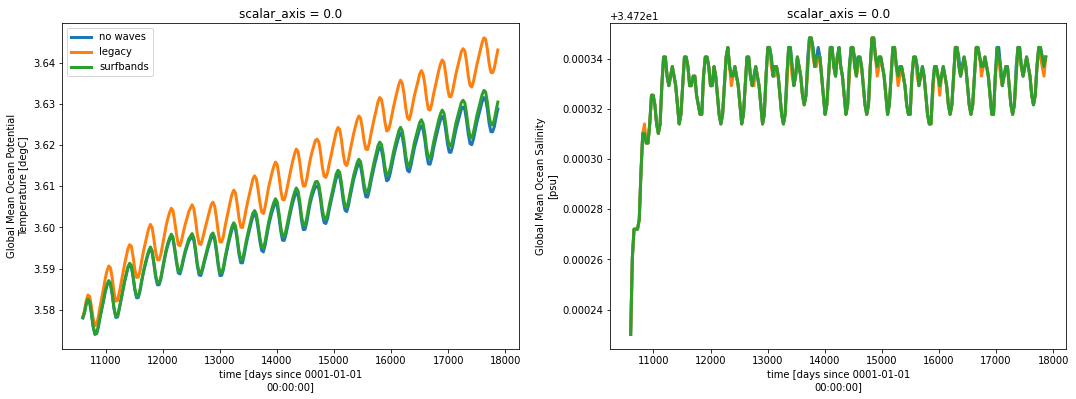

In [24]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
nw1_mom_hm.thetaoga.plot(ax=ax[0],label='no waves',lw=3)
lg1_mom_hm.thetaoga.plot(ax=ax[0],label='legacy',lw=3)
sb1_mom_hm.thetaoga.plot(ax=ax[0],label='surfbands',lw=3)
ax[0].legend()
nw1_mom_hm.soga.plot(ax=ax[1],label='no waves',lw=3)
lg1_mom_hm.soga.plot(ax=ax[1],label='legacy',lw=3)
sb1_mom_hm.soga.plot(ax=ax[1],label='surfbands',lw=3)

# Total KE (Joules)

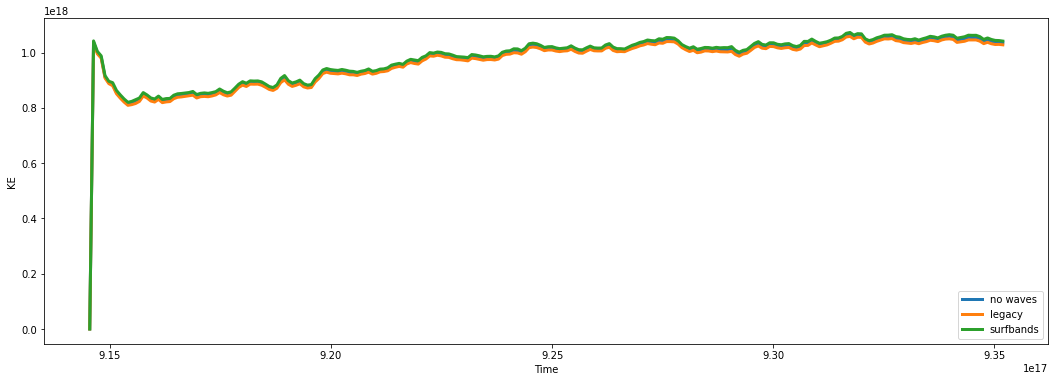

In [25]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
nw1_mom_os.KE.sum(axis=1).plot(ax=ax,label='no waves',lw=3)
lg1_mom_os.KE.sum(axis=1).plot(ax=ax,label='legacy',lw=3)
sb1_mom_os.KE.sum(axis=1).plot(ax=ax,label='surfbands',lw=3)
ax.legend()

# WAB - Stokes Forces Terms at surface. 5-year means: years 45-49

In [26]:
casename = "g.e23.GMOM_JRA_WD.TL319_t061_wt061.control.surfbands.001"
datasets = []
for year in range(45,50):
    ds = xr.open_mfdataset("/glade/scratch/altuntas/archive/{}/ocn/hist/*.mom6.hm_00{}*.nc".format(casename, year))
    datasets.append(ds)                 
sb1_mom_stokes = xr.concat(datasets, dim='time')

## Stokes pressure gradient force

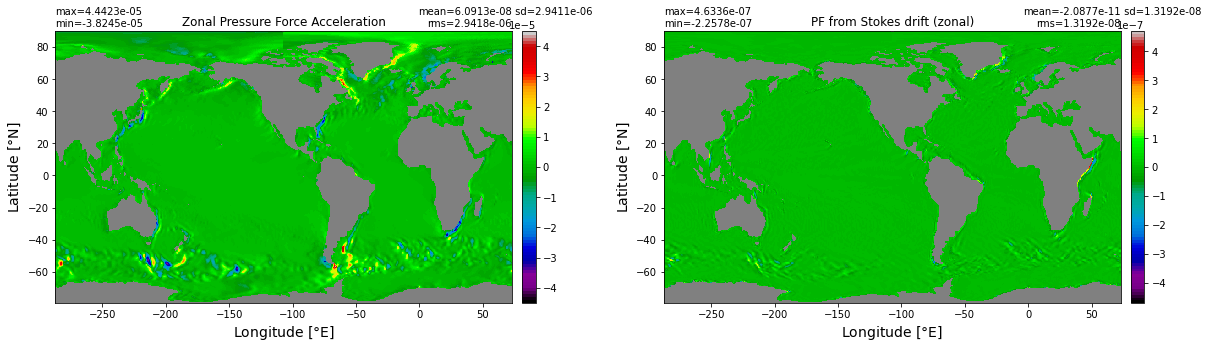

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = ax.flatten()

fld1 = sb1_mom_stokes.PFu.isel(zl=1); fld1_mean = fld1.mean(dim='time')
fld2 = sb1_mom_stokes.PFu_Stokes.isel(zl=1); fld2_mean = fld2.mean(dim='time')

xyplot(np.ma.masked_invalid(fld1_mean), grd.geolon, grd.geolat, grd.area_t, title=fld1.long_name, 
       axis=ax1[0], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld1_mean) )
xyplot(np.ma.masked_invalid(fld2_mean), grd.geolon, grd.geolat, grd.area_t, title=fld2.long_name, 
       axis=ax1[1], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld2_mean) )

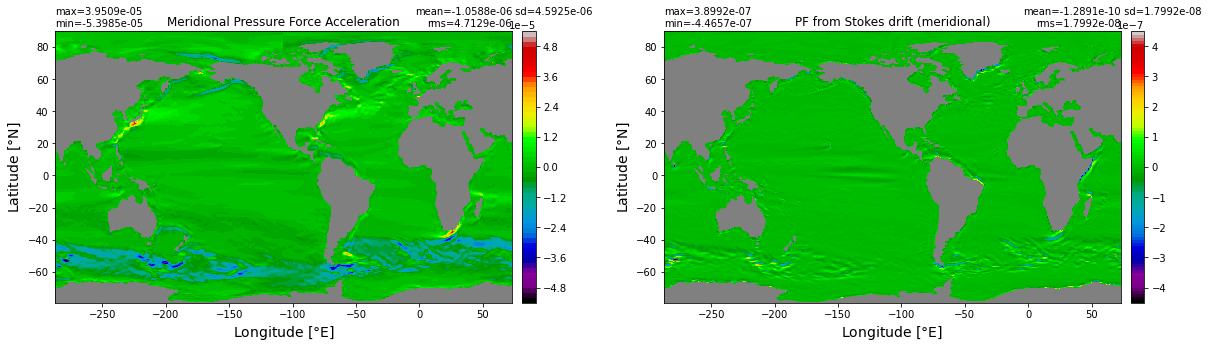

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = ax.flatten()

fld1 = sb1_mom_stokes.PFv.isel(zl=1); fld1_mean = fld1.mean(dim='time')
fld2 = sb1_mom_stokes.PFv_Stokes.isel(zl=1); fld2_mean = fld2.mean(dim='time')

xyplot(np.ma.masked_invalid(fld1_mean), grd.geolon, grd.geolat, grd.area_t, title=fld1.long_name, 
       axis=ax1[0], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld1_mean) )
xyplot(np.ma.masked_invalid(fld2_mean), grd.geolon, grd.geolat, grd.area_t, title=fld2.long_name, 
       axis=ax1[1], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld2_mean) )

## Stokes vortex force

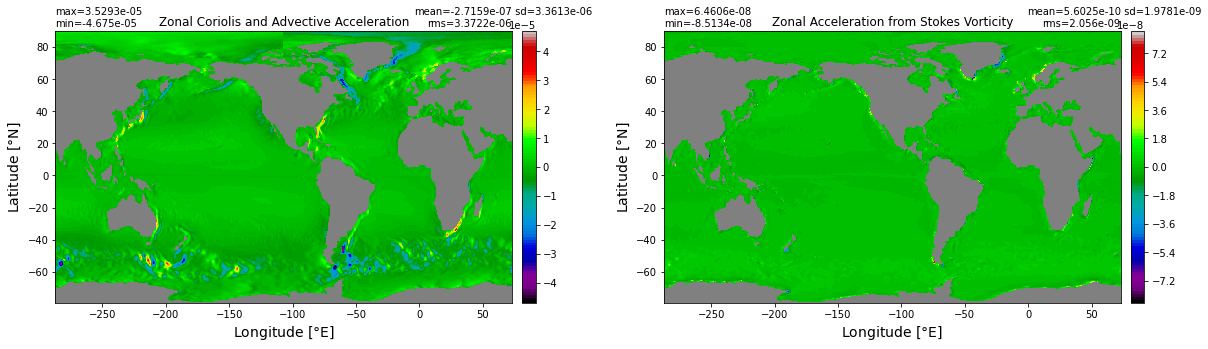

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = ax.flatten()

fld1 = sb1_mom_stokes.CAu.isel(zl=1); fld1_mean = fld1.mean(dim='time')
fld2 = sb1_mom_stokes.CAu_Stokes.isel(zl=1); fld2_mean = fld2.mean(dim='time')

xyplot(np.ma.masked_invalid(fld1_mean), grd.geolon, grd.geolat, grd.area_t, title=fld1.long_name, 
       axis=ax1[0], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld1_mean) )
xyplot(np.ma.masked_invalid(fld2_mean), grd.geolon, grd.geolat, grd.area_t, title=fld2.long_name, 
       axis=ax1[1], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld2_mean) )

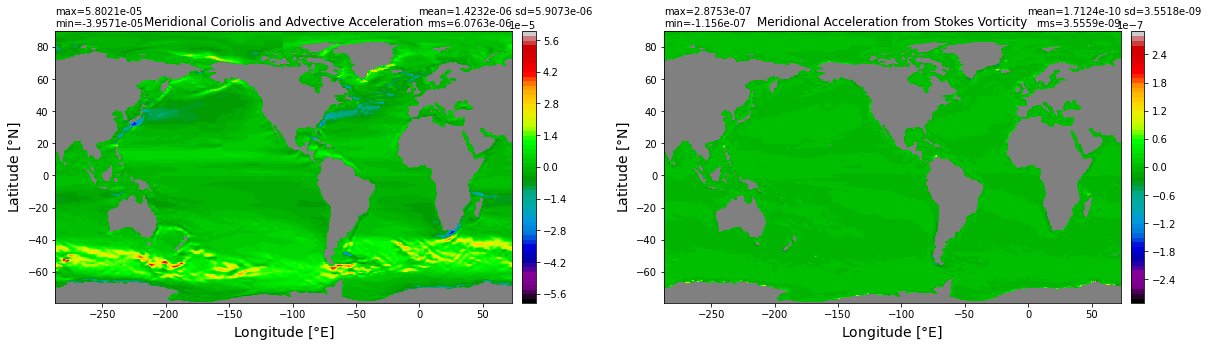

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = ax.flatten()

fld1 = sb1_mom_stokes.CAv.isel(zl=1); fld1_mean = fld1.mean(dim='time')
fld2 = sb1_mom_stokes.CAv_Stokes.isel(zl=1); fld2_mean = fld2.mean(dim='time')

xyplot(np.ma.masked_invalid(fld1_mean), grd.geolon, grd.geolat, grd.area_t, title=fld1.long_name, 
       axis=ax1[0], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld1_mean) )
xyplot(np.ma.masked_invalid(fld2_mean), grd.geolon, grd.geolat, grd.area_t, title=fld2.long_name, 
       axis=ax1[1], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld2_mean) )

## Stokes du/dt

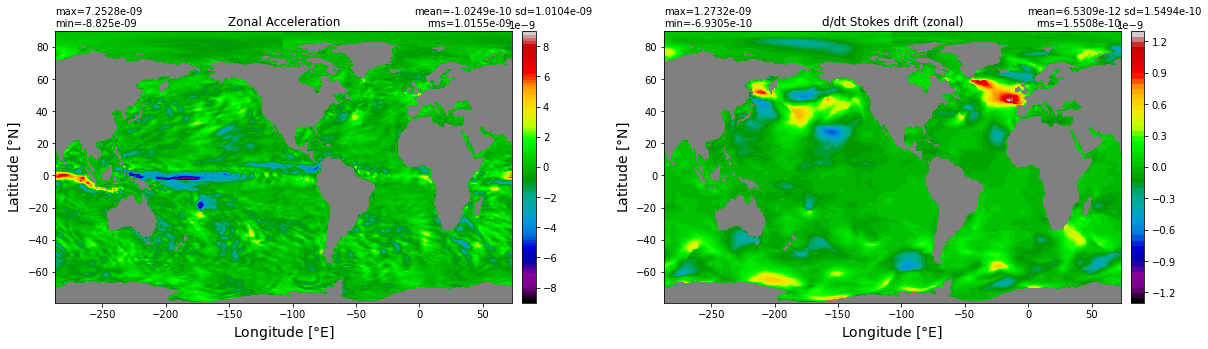

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = ax.flatten()

fld1 = sb1_mom_stokes.dudt.isel(zl=1); fld1_mean = fld1.mean(dim='time')
fld2 = sb1_mom_stokes.dudt_Stokes.isel(zl=1); fld2_mean = fld2.mean(dim='time')

xyplot(np.ma.masked_invalid(fld1_mean), grd.geolon, grd.geolat, grd.area_t, title=fld1.long_name, 
       axis=ax1[0], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld1_mean) )
xyplot(np.ma.masked_invalid(fld2_mean), grd.geolon, grd.geolat, grd.area_t, title=fld2.long_name, 
       axis=ax1[1], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld2_mean) )

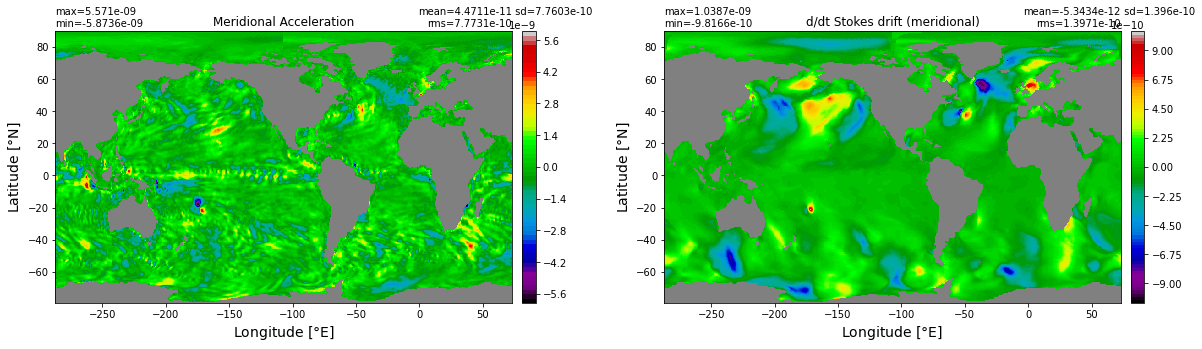

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1 = ax.flatten()

fld1 = sb1_mom_stokes.dvdt.isel(zl=1); fld1_mean = fld1.mean(dim='time')
fld2 = sb1_mom_stokes.dvdt_Stokes.isel(zl=1); fld2_mean = fld2.mean(dim='time')

xyplot(np.ma.masked_invalid(fld1_mean), grd.geolon, grd.geolat, grd.area_t, title=fld1.long_name, 
       axis=ax1[0], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld1_mean) )
xyplot(np.ma.masked_invalid(fld2_mean), grd.geolon, grd.geolat, grd.area_t, title=fld2.long_name, 
       axis=ax1[1], nbins=100, colormap=plt.cm.nipy_spectral, clim=get_clim(fld2_mean) )